In [11]:
import numpy as np
import cv2 as cv
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import torch
from pathlib import Path

from lac.perception.segmentation import UnetSegmentation
from lac.perception.depth import (
    stereo_depth_from_segmentation,
    project_pixel_to_rover,
    compute_rock_coords_rover_frame,
    compute_rock_radii,
)
from lac.control.controller import ArcPlanner
from lac.utils.visualization import overlay_mask, overlay_stereo_rock_depths
from lac.utils.plotting import (
    plot_points_rover_frame,
    plot_path_rover_frame,
    plot_rocks_rover_frame,
)
from lac.utils.frames import invert_transform_mat, apply_transform
from lac.util import load_data, get_positions_from_poses
import lac.params as params

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Obstacle detection


In [12]:
segmentation = UnetSegmentation()

In [23]:
data_path = Path("../../output/AutoAgent/arc_planner_test")
data_path = Path("../../../output/RecoveryAgent/default_run")
initial_pose, lander_pose, poses, imu_data, cam_config = load_data(data_path)

(-0.5, 1279.5, 719.5, -0.5)

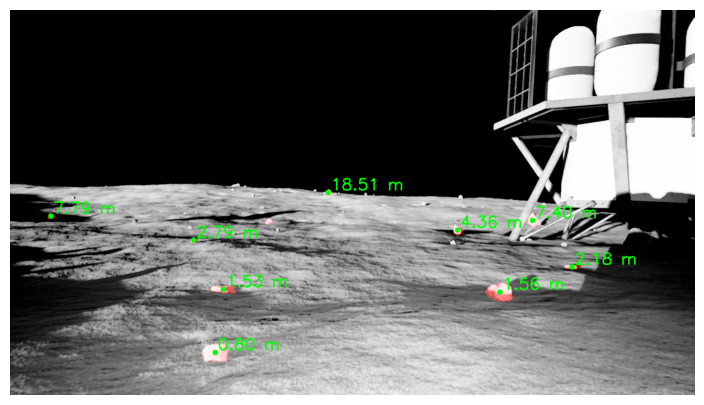

In [24]:
i = 214

left_image = cv.imread(data_path / "FrontLeft" / f"{i:06}.png", cv.IMREAD_GRAYSCALE)
right_image = cv.imread(data_path / "FrontRight" / f"{i:06}.png", cv.IMREAD_GRAYSCALE)

left_masks, left_labels = segmentation.segment_rocks(left_image)
right_masks, right_labels = segmentation.segment_rocks(right_image)
left_seg_full_mask = np.clip(left_labels, 0, 1).astype(np.uint8)
right_seg_full_mask = np.clip(right_labels, 0, 1).astype(np.uint8)

results = stereo_depth_from_segmentation(left_masks, right_masks, params.STEREO_BASELINE, params.FL_X)
left_overlay = overlay_mask(np.array(left_image), left_seg_full_mask)
left_overlay = overlay_stereo_rock_depths(left_overlay, results)
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.imshow(left_overlay)
plt.axis("off")

In [25]:
# TODO: use compute_rock_points and compute_rock_radii

In [26]:
x, _, w, _ = cv.boundingRect(results[0]["left_mask"].astype(np.uint8))
width_x = w * results[0]["depth"] / params.FL_X
print(f"Width: {width_x} m")

Width: 0.09529411761903114 m


In [27]:
lander_local = apply_transform(invert_transform_mat(poses[i]), params.LANDER_GLOBAL)
lander_local

array([[ 6.77836566, -2.14018388, -1.6849891 ],
       [ 4.92340267, -4.49633567, -1.77251666],
       [ 2.56603704, -2.64505497, -1.64766855],
       [ 4.42100003, -0.28890318, -1.560141  ]])

In [28]:
rock_points_rover_frame = []
rock_data = compute_rock_radii(results)

for rock in results:
    rock_points_rover_frame.append(
        project_pixel_to_rover(rock["left_centroid"], rock["depth"], "FrontLeft", cam_config)
    )

rock_points_rover_frame = np.array(rock_points_rover_frame)
# print(rock_points_rover_frame)
fig = go.Figure()
fig.add_trace(go.Scatter(x=lander_local[:, 1], y=lander_local[:, 0], fill="toself", name="lander"))
fig = plot_rocks_rover_frame(rock_points_rover_frame, rock_data, fig=fig, color="red")
fig.show()

In [29]:
rock_data

[0.04764705880951557,
 0.021396226411057317,
 0.035735294112391874,
 0.04433684210059613,
 0.04008247422267192,
 0.02189189189070855,
 0.18224999977218753,
 0.11339999994330002,
 0.0682105262798892]

## Arc path planning


In [30]:
planner = ArcPlanner()


arcs = planner.np_candidate_arcs

In [31]:
print(rock_points_rover_frame)
test_rock_points_rover_frame = np.array([[0.5, 0.5], [0.4, -0.4], [0.2, 0.3]])

[[ 4.63501354 -0.85288235 -0.112     ]
 [ 3.07378227  0.98881132 -0.08296226]
 [ 2.45750677 -0.89576471 -0.15488235]
 [ 1.83863643 -0.38794737 -0.15377895]
 [ 1.80649959  0.48516495 -0.1395567 ]
 [ 1.08038087  0.30604865 -0.11418919]
 [18.78880753  1.0125      0.51575   ]
 [ 7.68352302 -2.6406     -0.1363    ]
 [ 8.07318212  4.8898421  -0.08215789]]


In [32]:
test_rock_data = [0.07, 0.06, 0.05]

In [35]:
# print(f"candidate arcs shape: {planner.np_candidate_arcs.shape}")
waypoint = np.array([4.25, 4.25])
current_pose = poses[i]
test_rock_points_rover_frame = np.array([[]])
test_rock_data = []
control, best_arc, waypoint_local = planner.plan_arc(waypoint, current_pose, rock_points_rover_frame, rock_data)
# (v,w), waypoint_local = planner.plan_arc(waypoint, current_pose, test_rock_points_rover_frame, test_rock_data)
# print(waypoint_local)
fig = plot_rocks_rover_frame(rock_points_rover_frame, rock_data, color="red")
print(f"waypoint_local{waypoint_local}")
# fig = go.Figure()
for arc in arcs:
    fig = plot_path_rover_frame(arc, fig=fig)
fig = plot_path_rover_frame(best_arc, color="green", fig=fig)

fig.show()
print(control)

waypoint_local[ 5.38393843 -8.35314879 -1.96719434  1.        ]


(0.2, -0.5)


# Arc overlay visualization


In [ ]:
from lac.utils.camera import Camera
from lac.utils.frames import get_cam_pose_rover, CAMERA_TO_OPENCV_PASSIVE
from lac.utils.plotting import plot_poses

In [ ]:
def rover_pose_to_cam_pose(rover_pose, cam_name="FrontLeft"):
    camera_pose = get_cam_pose_rover(cam_name)
    camera_pose[:3, :3] = CAMERA_TO_OPENCV_PASSIVE
    return rover_pose @ camera_pose

In [ ]:
# data_path = Path("../../output/AutoAgent/arc_planner_test")
data_path = Path("../../output/NavAgent/map1_preset4_eval")
initial_pose, lander_pose, poses, imu_data, cam_config = load_data(data_path)

In [ ]:
cam_poses = []
for pose in poses:
    cam_poses.append(rover_pose_to_cam_pose(pose))

In [ ]:
plot_poses(cam_poses[::100])

In [ ]:
cam = Camera(cam_poses[0])

# TODO: define arc points
arc_points = None

uv, depths = cam.project_world_points_to_uv(arc_points)

In [ ]:
plt.scatter(uv[:, 0], uv[:, 1], cmap="plasma")
# Set x and y limits
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis()
plt.show()